In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import pandas as pd
import statsmodels.api as sm
import cmocean
import warnings
import statsmodels as sm
warnings.filterwarnings('ignore')

Comparing Upper Ocean Heat Content (0 - 100 Meters) from the CA 4DVAR ROMS output with the _in situ_ data from the M1 buoy

Start by loading the respective datasets

In [3]:
m1_heat = pd.read_csv('../data/m1_upper_ocean_heat_content.csv')
m1_heat = m1_heat.drop(columns='dateTime.1')
m1_heat.index = pd.to_datetime(m1_heat['dateTime'])
roms_heat = pd.read_csv('../data/roms_m1_heat_content.csv')
roms_heat.index = pd.to_datetime(roms_heat['dateTime'])

__Downscale the data to daily values (for M1)__

In [4]:
roms_daily_heat = roms_heat['heatContent'].resample('1D').mean()
m1_daily_heat = m1_heat['heatContent'].resample('1D').mean()
daily_heat = pd.DataFrame(columns=['m1','roms'])
daily_heat['m1'] = m1_daily_heat
daily_heat['roms'] = roms_daily_heat.loc[m1_daily_heat.index]
daily_heat['m1'] = daily_heat['m1'] / 1E9
daily_heat['roms'] = daily_heat['roms'] / 1E9

daily_heat.dropna(axis=0, inplace=True) # Drop any row a NaN for model fitting later

In [5]:
def plot_linear_reg(df,column,ax):
    '''plot a linear regression linear to a plot'''
    x = np.arange(df.index.size) # = array([0, 1, 2, ..., 3598, 3599, 3600])
    fit = np.polyfit(x, df[column].values, 1)
    fit_fn = np.poly1d(fit)
    ax.plot(df.index, fit_fn(x), 'k-')

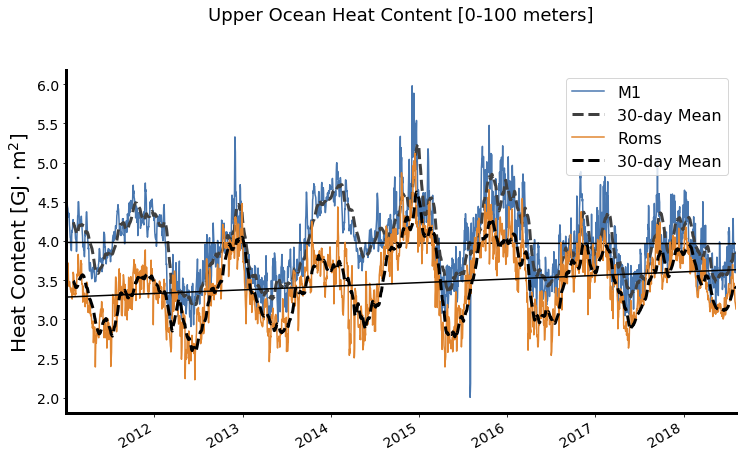

In [125]:
fig, ax = plt.subplots()
fig.set_size_inches(12,7)
# plot m1
daily_heat['m1'].plot(ax=ax,label='M1',color="#4877b0")
daily_heat['m1'].rolling(30).mean().plot(ax=ax,lw=3,ls='dashed',label='30-day Mean',color=".25")
plot_linear_reg(daily_heat, 'm1', ax=ax)

# Plot 4DVar Roms
daily_heat['roms'].plot(ax=ax,label='Roms',color="#e1852f")
daily_heat['roms'].rolling(30).mean().plot(ax=ax,lw=3,ls='dashed',label='30-day Mean',color="k")
plot_linear_reg(daily_heat, 'roms', ax=ax)

## Format the Plot ##
ax.set_ylabel(r'Heat Content [$ \mathrm {GJ \cdot m^2} $]', size=20)
ax.set_xlabel('')

plt.legend(fontsize=16)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#Change spine width
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
# Increase Label size
ax.tick_params(axis='both', labelsize=14, )
plt.title('Upper Ocean Heat Content [0-100 meters]', size=18,pad=50)
# plt.savefig('m1_roms_upper_heat_content.png', dpi=300, bbox_inches='tight', pad_inches=.25)


Remake Plots using Seaborn - Requires passing Function Formatter 

In [86]:
df = daily_heat
import seaborn as sns; 
sns.set(color_codes=True)

daily_heat['dateTime'] = daily_heat.index 
daily_heat['datenum'] = daily_heat['dateTime'].astype(int) / 10**9

@plt.FuncFormatter
def fake_dates(x, pos):
    """ Custom formater to turn floats into e.g., 2016-05-08"""
    return pd.to_datetime(x, unit='s', origin='unix').strftime('%Y-%m-%d')

Text(0.5, 0, '')

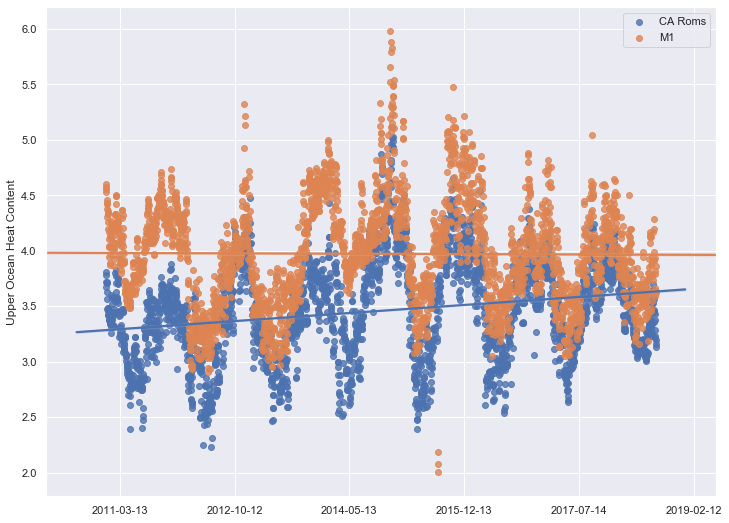

In [91]:
fig, ax = plt.subplots()
fig.set_size_inches(12,9)
# just use regplot if you don't need a FacetGrid
sns.regplot('datenum', 'roms', data=daily_heat, ax=ax, ci=68, label='CA Roms')
# here's the magic:
ax.xaxis.set_major_formatter(fake_dates)
# legible labels
ax.tick_params(labelrotation=45)

sns.regplot('datenum', 'm1', data=daily_heat, ax=ax, ci=68, label='M1')
# here's the magic:
ax.xaxis.set_major_formatter(fake_dates)
# legible labels
ax.tick_params(labelrotation=0)
plt.legend()
ax.set_ylabel('Upper Ocean Heat Content')
ax.set_xlabel("")

Linear Correlations between M1 and Roms

In [45]:
daily_heat.corr(method='pearson')

,m1,roms
m1,1.000000,0.750536
roms,0.750536,1.000000


In [59]:
model = sm.OLS(daily_heat['roms'], daily_heat['m1']).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   roms   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                          3.522e+05
Date:                Thu, 31 Oct 2019   Prob (F-statistic):                        0.00
Time:                        13:30:24   Log-Likelihood:                         -58138.
No. Observations:                2773   AIC:                                  1.163e+05
Df Residuals:                    2772   BIC:                                  1.163e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
m1             0.8686      0.001    593.451      0.000       0.866       0.871
==============================================================================
Omnibus:                       40.380   Durbin-Watson:                   0.341
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.944
Skew:                          -0.045   Prob(JB):                     1.45e-16
Kurtosis:                       3.790   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

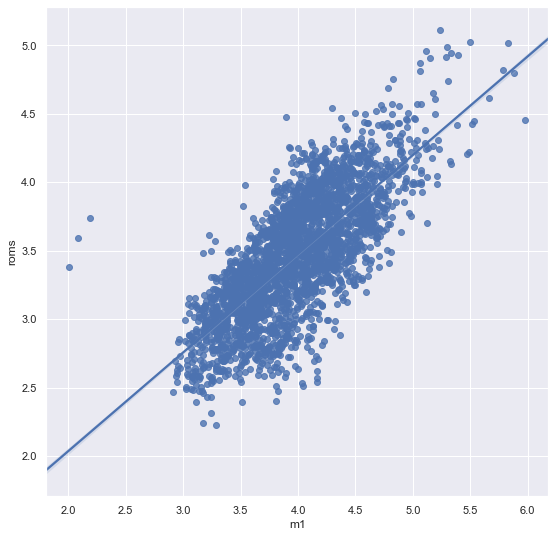

In [92]:
fig, ax = plt.subplots()
fig.set_size_inches(9,9)
# just use regplot if you don't need a FacetGrid
sns.regplot('m1', 'roms', data=daily_heat, ax=ax, ci=68)

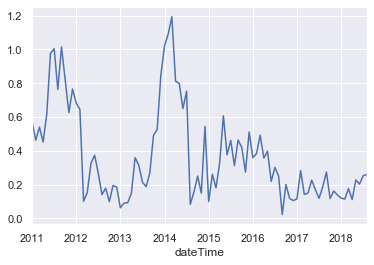

In [102]:
(((df['roms'] - df['m1'])**2).resample('1M').sum()/((df['roms'] - df['m1'])**2).resample('1M').count()).plot()

In [1]:
fig, ax = plt.subplots()
(((df['roms'] - df['m1'])**2).resample('1y').sum()/((df['roms'] - df['m1'])**2).resample('1y').count()).plot(kind='bar',ax=ax)

NameError: name 'plt' is not defined

In [109]:
roms_heat.shape

(3220, 3)